In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

### First load in the data

In [3]:
from pathlib import Path
import random


import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import torch
import torch.utils.data


from src.data import DataPaths, Image, open_numpy

#### Load the training images

In [4]:
from pytorch_toolbox.fastai.fastai import vision

In [5]:
train_paths = list(DataPaths.TRAIN_ALL_COMBINED_IMAGES.glob("*"))
test_paths = list(DataPaths.TEST_IMAGES.glob("*"))

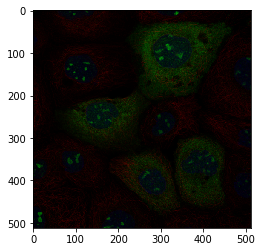

In [6]:
sample_path = random.sample(train_paths, 1)[0]
sample_img = open_numpy(sample_path)
plt.imshow(sample_img.px[:,:,:3])

##### Image augmentation

In [7]:
from functools import partial

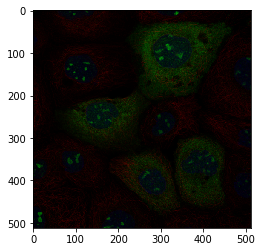

In [8]:
plt.imshow(sample_img.px[:,:,:3])

In [9]:
import numpy as np
from pytorch_toolbox.vision.transforms import very_simple_aug
from albumentations import Compose, Resize

def albumentations_transform_wrapper(image, augment_fn):
    augmentation = augment_fn(image=image.px)
    return augmentation['image']

augment_fn = partial(albumentations_transform_wrapper, augment_fn=very_simple_aug())

Plot out the results

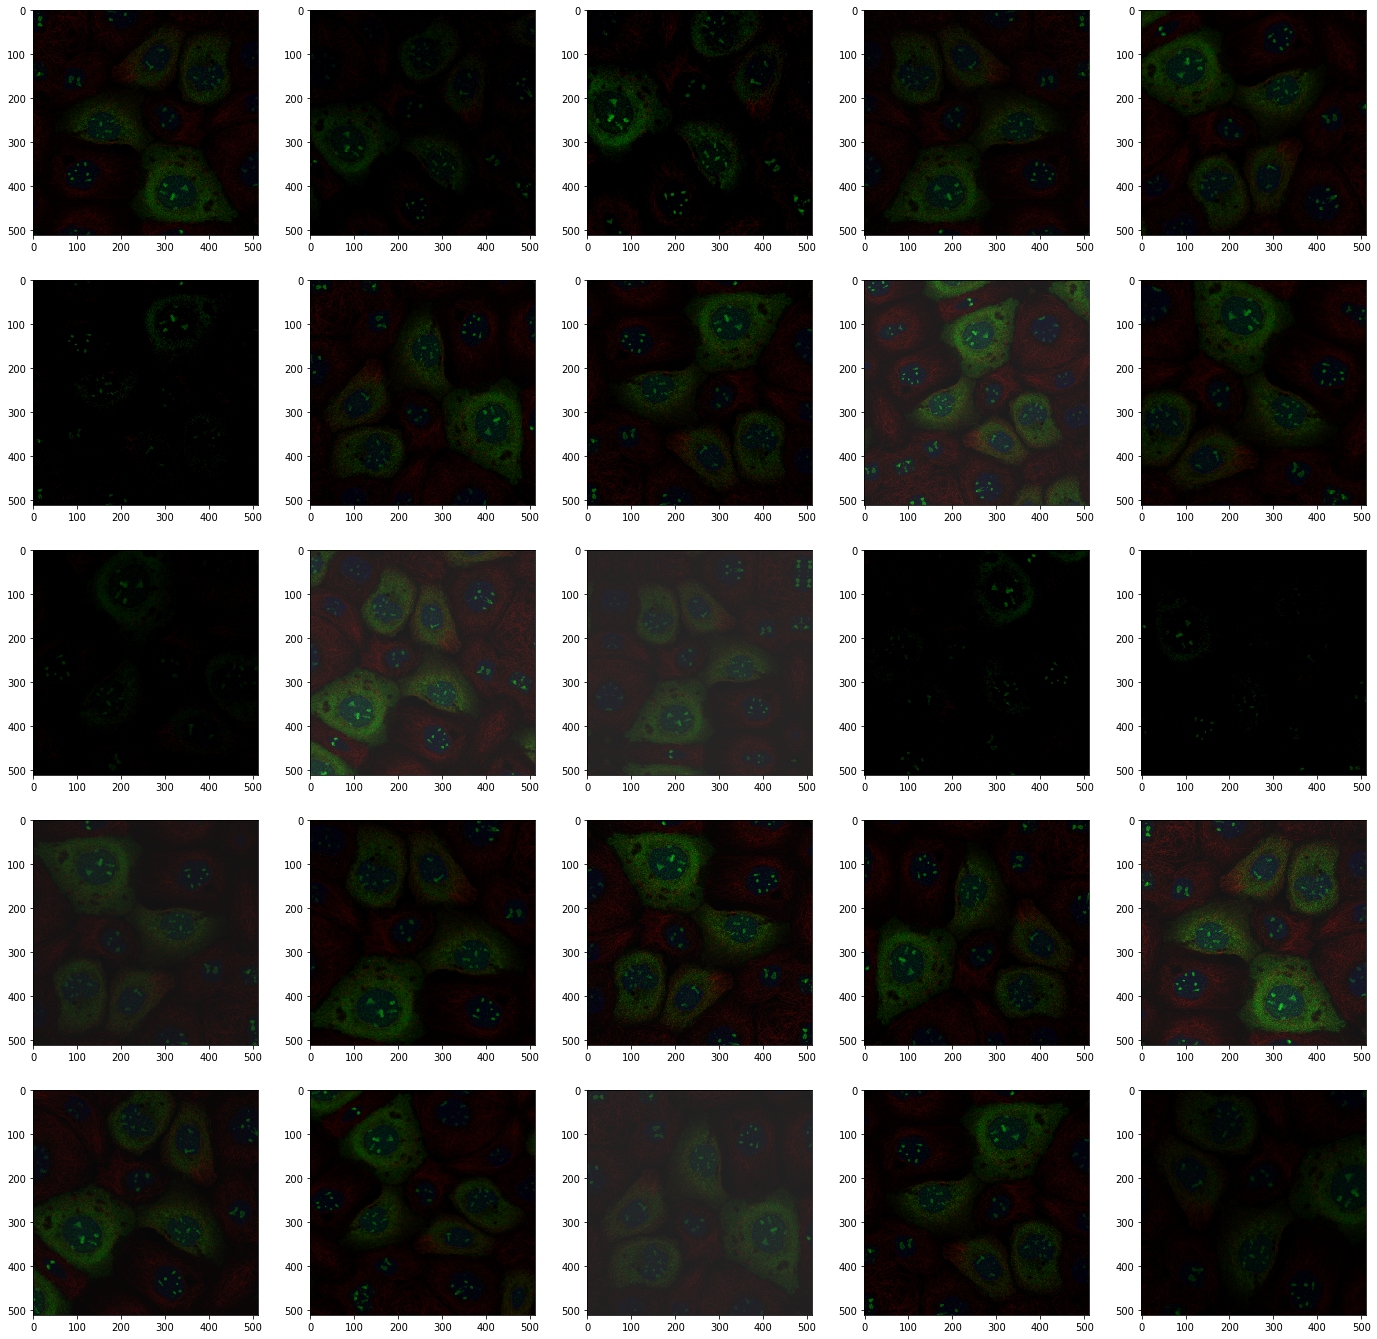

In [10]:
_, axs = plt.subplots(5, 5, figsize=(24, 24))
axs = axs.flatten()
for ax in axs:
    ax.imshow(augment_fn(sample_img)[:,:,:3])
#     ax.axis('off')

#### Load the training labels

In [11]:
labels_df = pd.read_csv(DataPaths.TRAIN_ALL_LABELS)
labels_df['Target'] = [[int(i) for i in s.split()] for s in labels_df['Target']]

In [12]:
labels_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18]


In [13]:
label = labels_df.loc[labels_df["Id"] == sample_path.stem]['Target'].values[0]

In [14]:
label

[25, 2]

##### Generate one hot labels

In [15]:
train_labels_one_hot = []
train_labels = labels_df['Target']
for labels in tqdm_notebook(train_labels):
    one_hot = np.zeros((28))
    for label in labels:
        one_hot[label] = 1
    train_labels_one_hot.append(one_hot.astype(np.float32))

In [16]:
# train_labels[0]
train_labels_one_hot[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

#### Now generate training input/label pairs

In [17]:
train_paths = sorted(train_paths, key=lambda p: p.name)

In [18]:
labels_df = labels_df.sort_values(["Id"], ascending=[True])

In [19]:
np.all(np.array([p.stem for p in train_paths]) == labels_df["Id"])

True

In [20]:
train_labels = labels_df["Target"].values

In [21]:
len(train_paths) == len(train_labels)

True

#### Load data into dataset

In [22]:
from functools import partial
from src.data import ProteinClassificationDataset
from pytorch_toolbox.utils.image import normalize, denormalize, tensor2img

Create a normalization function, as ImageNet is trained on 3 channel inputs, but our image is 4 channels we will use the pretrained weights from the first channel as the 4th channel, hence we will need to adjust our normalization function accordingly

In [23]:
four_channel_image_net_stats = {
    'mean': [0.485, 0.456, 0.406, 0.485],
    'sd': [0.229, 0.224, 0.224, 0.229]
}
four_channel_image_net_normalize = partial(normalize, **four_channel_image_net_stats)
four_channel_image_net_denormalize = partial(denormalize, **four_channel_image_net_stats)

In [24]:
ds = ProteinClassificationDataset(train_paths, open_image_fn=open_numpy, image_cached=False, labels=train_labels_one_hot, augment_fn=augment_fn, normalize_fn=four_channel_image_net_normalize)

In [25]:
batch = next(iter(ds))
inp, name, label = batch['input'], batch['name'], batch['label']

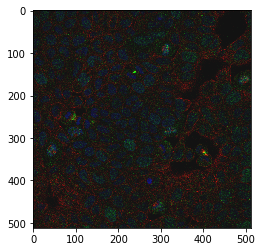

In [26]:
plt.imshow(tensor2img(inp, denorm_fn=four_channel_image_net_denormalize)[:,:,:3])

#### Define the loss to be used

In [27]:
import torch.nn as nn
from pytorch_toolbox.fastai_extensions.loss import LossWrapper, FocalLoss, SoftF1Loss

#### Create the data bunch

In [28]:
from functools import partial
from sklearn.model_selection import ShuffleSplit
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from pytorch_toolbox.fastai_extensions.basic_data import DataBunch
from src.data import single_class_counter
from torch.utils.data import WeightedRandomSampler

In [29]:
split_method = partial(MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split, X=train_paths, y=train_labels_one_hot)

In [30]:
len(train_paths)

105678

In [31]:
len(train_labels_one_hot)

105678

In [32]:
def get_splits(split_method):
    return next(iter(split_method()))

In [33]:
def create_data_bunch(train_ds, val_ds, test_ds, sampler=None, **data_bunch_parameters):
    data = DataBunch.create(train_ds, val_ds, test_ds,
                            collate_fn=train_ds.collate_fn,
                            sampler=sampler,
                            **data_bunch_parameters)

    return data

def generate_weight_lookup(all_labels):
    label_proportions = single_class_counter(all_labels)
    weight_lookup = {label: 1 / prop for label, prop in label_proportions}
    return weight_lookup


def create_weights(all_labels):
    all_weights = []
    weight_lookup = generate_weight_lookup(all_labels)
    for labels in all_labels:
        weights = np.array([weight_lookup[l] for l in labels]).mean()
        all_weights.append(weights)
    return all_weights

In [34]:
train_idx, val_idx = next(iter(split_method()))
weights = create_weights(labels_df['Target'].values[train_idx])
sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)

train_ds = ProteinClassificationDataset(inputs=np.array(train_paths)[train_idx],
                   open_image_fn=open_numpy,
                   labels=np.array(train_labels_one_hot)[train_idx],
                   augment_fn=augment_fn,
                   normalize_fn=four_channel_image_net_normalize)
val_ds = ProteinClassificationDataset(inputs=np.array(train_paths)[val_idx],
                 open_image_fn=open_numpy,
                 labels=np.array(train_labels_one_hot)[val_idx],
                 normalize_fn=four_channel_image_net_normalize)
test_ds = ProteinClassificationDataset(inputs=np.array(test_paths),
                  open_image_fn=open_numpy,
                  normalize_fn=four_channel_image_net_normalize)

data = create_data_bunch(train_ds, val_ds, test_ds,
                         train_bs=32, val_bs=32, test_bs=32)

In [35]:
batch = next(iter(data.train_dl))

In [36]:
inp, name, label = batch[0], batch[1]['name'], batch[1]['label']

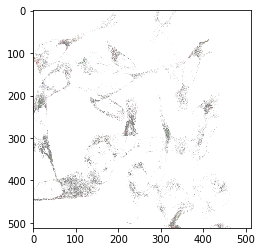

In [37]:
plt.imshow(tensor2img(inp[20], denorm_fn=four_channel_image_net_denormalize))

#### Initializing the model

In [38]:
import pytorch_toolbox.fastai.fastai as fastai
from pytorch_toolbox.fastai_extensions.basic_train import Learner
from src.models import cbam_resnet50_four_channel_input, resnet50_four_channel_input, resnet34_four_channel_input, resnet18_four_channel_input, gapnet_resnet34_four_channel_input_backbone

In [39]:
# model = resnet50_four_channel_input(pretrained=False)
# model = resnet34_four_channel_input(pretrained=True)
# model = resnet18_four_channel_input(pretrained=True)
# n_starting_layers = len(fastai.flatten_model(model[:6]))
# n_middle_layers = len(fastai.flatten_model(model[6:9]))
# n_head = len(fastai.flatten_model(model[9:]))
# layer_groups = fastai.split_model_idx(model, [n_starting_layers, n_starting_layers + n_middle_layers])
model = gapnet_resnet34_four_channel_input_backbone(pretrained=False)

../../src/models/__init__.py:32: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)


#### Initialize callbacks

##### For extracting relevant information from output of our data bunch

In [40]:
from pytorch_toolbox.fastai_extensions.callbacks import NameExtractionTrainer

##### For saving the results of our training

In [41]:
from collections import defaultdict
from pytorch_toolbox.utils import to_numpy
from src.callbacks import OutputRecorder

##### Define metric to track

In [42]:
from pytorch_toolbox.metrics import accuracy, f1_soft

#### Initialize Learner

In [43]:
learner = Learner(data,
#                   layer_groups=layer_groups,
                  model=model, 
                  loss_func=LossWrapper([
                      FocalLoss(gamma=0),
#                       SoftF1Loss()
                  ]),
                  callbacks=[NameExtractionTrainer()],
                  callback_fns=[partial(OutputRecorder, save_path=Path("/tmp"), save_img_fn=partial(tensor2img, denorm_fn=four_channel_image_net_denormalize))],
                  metrics=[accuracy, f1_soft])

##### Find optimal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


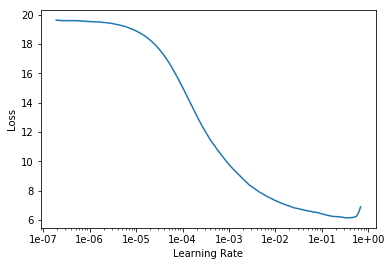

In [44]:
import warnings
warnings.filterwarnings('ignore')
# learner.lr_find(start_lr=[1e-7] * 3, end_lr=[1] * 3, num_it=250)
learner.lr_find(start_lr=[1e-7], end_lr=[1], num_it=250)
learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


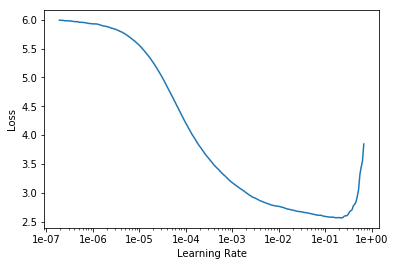

In [54]:
import warnings
warnings.filterwarnings('ignore')
# learner.lr_find(start_lr=[1e-7] * 3, end_lr=[1] * 3, num_it=250)
learner.lr_find(start_lr=[1e-7], end_lr=[1], num_it=250)
learner.recorder.plot()

In [103]:
# learner.output_recorder.history

In [45]:
def iafoss_training_scheme(learner):
    lr = 2e-2
    lrs=np.array([lr/10,lr/3,lr])
    learner.unfreeze_layer_groups(2)
    learner.fit(epochs=1, lr=[0, 0, lr])
    learner.unfreeze()
    learner.fit_one_cycle(cyc_len=16, max_lr=lrs/4)
    learner.fit_one_cycle(cyc_len=8, max_lr=lrs/16)

In [47]:
iafoss_training_scheme(learner)

epoch,train_loss,valid_loss,accuracy,f1_soft


AttributeError: 'numpy.float64' object has no attribute 'detach'

In [ ]:
learner.save("iafoss.pth")

In [ ]:
learner.recorder.losses[-1]

In [ ]:
learner.save("cbam_resnet50_cyc_len=15, max_lr=[8e-3] * 3")

#### Define a recorder for the test results

In [ ]:
from pytorch_toolbox.utils.core import to_numpy

In [ ]:
class ResultRecorder(fastai.Callback):
    _order = -10
    def __init__(self):
        self.names = []
        self.prob_preds = []
        self.targets = []
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train:
            self.phase = 'TRAIN'
        else:
            label = last_target.get('label')
            if label is not None:
                self.phase = 'VAL'
            else:
                self.phase = 'TEST'
#         inputs = tensor2img(last_input, denorm_fn=image_net_denormalize)
#         self.inputs.extend(inputs)
        self.names.extend(last_target['name'])
        if self.phase == 'TRAIN' or self.phase == 'VAL':
            label = to_numpy(last_target['label'])
            self.targets.extend(label)
            
    def on_loss_begin(self, last_output, **kwargs):
        prob_pred = to_numpy(torch.sigmoid(last_output))
        self.prob_preds.extend(prob_pred)

##### Run prediction on learner

In [ ]:
learner.load("iafoss.pth")
res_recorder = ResultRecorder()
learner.predict_on_dl(dl=learner.data.valid_dl, callbacks=[res_recorder])

In [ ]:
from sklearn.metrics import f1_score
import scipy.optimize as opt

In [ ]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
pred_probs = np.stack(res_recorder.prob_preds)
targets = np.stack(res_recorder.targets)
print(targets.shape)
print(pred_probs.shape)

In [ ]:
th = fit_val(pred_probs,targets)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(targets, pred_probs>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(targets, pred_probs>0.5, average='macro'))
print('F1 micro: ',f1_score(targets, pred_probs>th, average='micro'))

In [ ]:
np.where(np.sum(pred_probs > th, axis=1)

##### Now use the optimal threshold for making predictions

In [ ]:
learner.load("iafoss.pth")
res_recorder = ResultRecorder()
learner.predict_on_dl(dl=learner.data.test_dl, callbacks=[res_recorder])

In [ ]:
names = np.stack(res_recorder.names)
pred_probs = np.stack(res_recorder.prob_preds)
print(names.shape)
print(pred_probs.shape)

In [ ]:
predicted = []
for pred in tqdm_notebook(pred_probs):
    classes = [str(c) for c in np.where(pred > th)[0]]
    if len(classes) == 0:
        classes = [str(np.argmax(pred[0]))]
    predicted.append(" ".join(classes))

In [ ]:
submission_df = pd.DataFrame({
    "Id": names,
    "Predicted": predicted
})

In [ ]:
submission_df

In [ ]:
submission_df.to_csv("submission.csv", index=False)